In [1]:
import netCDF4
import shapely.geometry
import numpy as np
import functools

from shapely.strtree import STRtree

#%load_ext line_profiler

In [2]:
path = 'C:/Users/micha/data/odv/public/profiles/data_from_SDN_2015-09_TS_MedSea_QC_done_v2.nc'


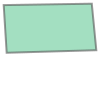

In [3]:
#south of Creta
geom = shapely.geometry.asShape({ 
    "type": "Polygon", 
    "coordinates":  [ [ [ 24.745606942684663, 34.895011468818964 ], [ 25.290330152765776, 34.903602998242697 ], 
[ 25.318264676359679, 34.616016550183943 ], [ 24.763938973793167, 34.600209773077722 ], [ 24.745606942684663, 34.895011468818964 ] ] ]
    })
geom


In [17]:
#for idx in idxs:
timeframe = [2003, 2004, 2005]
def indexes_of_year(year, indexes = indexes, ds = ds):
    for idx in indexes:
        date_nums = ds.variables['date_time'][idx] 
        date_units = ds.variables['date_time'].units
        date = netCDF4.num2date(date_nums, date_units)
        if date.year == year:
            return idx


NameError: name 'ds' is not defined

In [5]:
@functools.lru_cache()
def tree_from_path(path):
    # get lat, lon from the dataset
    with netCDF4.Dataset(path) as ds:
        lon = ds.variables['longitude'][:]
        lat = ds.variables['latitude'][:]
    
    # create spatial points so that we can query by geometry
    points = [
        shapely.geometry.Point(lon_i, lat_i) 
        for lon_i, lat_i 
        in zip(lon, lat)
    ]

    index_by_id = dict((id(pt), i) for i, pt in enumerate(points))
    tree = STRtree(points)
    return tree, index_by_id


In [6]:
def query_tree(tree, index_by_id, geom):
    """lookup the indices by geometry"""
    shapes = tree.query(geom)
    idx = [
        index_by_id[id(pt)] for pt in shapes
    ]
    # improves performance by a factor of 3
    # sort to make it faster
    idx = list(sorted(idx))
    return idx


In [10]:
tree, index_by_id = tree_from_path(path)
indexes = query_tree(tree, index_by_id, geom)
indexes

[4972,
 4973,
 5506,
 5662,
 6371,
 6882,
 70476,
 109190,
 119784,
 150432,
 150434,
 150922,
 150925,
 178927,
 188164,
 190428,
 190770,
 193559,
 202535,
 203980,
 204487,
 207215]

In [18]:
years = [2004,2005,2006]
[indexes_of_year(x, indexes, ds) for x in years]

NameError: name 'ds' is not defined

In [44]:
def query_path_by_geometry(path, geom, max_n=300):
    tree, index_by_id = tree_from_path(path)
    idx = query_tree(tree, index_by_id, geom)

    print (idx)
    if len(idx) > max_n:
        # if we have more than 300 stationss this function takes over 5s
        # let's just return a random sample of 1000 points
        sample = np.random.choice(idx, max_n, replace=False)
        # sort and rename to idx
        idx = list(sorted(sample))
    
    # now that we have <=max_n ids, get the data for each of them. 
    with netCDF4.Dataset(path) as ds:

        # create a list with the var that contain the temperature, salinity and depth values
        var_names = [
            name
            for name, var
            in ds.variables.items()
            if (name.startswith('var') and not '_' in name)
        ]
        var_names

        idx_variables = {}
        for var_name in var_names:
            var = ds.variables[var_name]

            try:
                idx_variables[var.long_name] = var[idx]
            except AttributeError:
                print ("failed to index {} with index {}".format(var,  idx))
    return idx_variables


In [41]:
# first call will cache the tree for this path
tree, index_by_id = tree_from_path(path)


In [46]:
#%%timeit
# now we can query a 300 point sample from a 10000 station covering geometry in 2s
idx_variables = query_path_by_geometry(path, geom)


[4972, 4973, 5506, 5662, 6371, 6882, 70476, 109190, 119784, 150432, 150434, 150922, 150925, 178927, 188164, 190428, 190770, 193559, 202535, 203980, 204487, 207215]
